Created on Mon Apr 15 16:14 2019

This is the script to plot Figure 6 containing the uncertainty introduced by the data assimilation

and to plot Figure 8, containing 
   * observation
   * the mean minimal difference between simulation and observations
   * the mean maximal difference between simulation and observations
   * the difference in sea-ice concentration between BT and NT

@author: Clara Burgard

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
import seaborn as sns

In [2]:
import sys
sys.path.append('./arc3o')
import core_functions as arc3o
import arc3o_analysis_functions as sana

In [ ]:
sns.set_context('paper')

In [3]:
obs_inputpath = '/work/mh0033/m300411/SatSim/WORK_DATA/observations/'
orig_MPIESM_inputpath = '/work/mh0033/m300411/SatSim/WORK_DATA/assimilation_runs/'
orig_SIC_inputpath = '/work/mh0033/m300411/SatSim/WORK_DATA/observations/'
TB_inputpath = '/work/mh0033/m300411/SatSim/WORK_DATA/simulated_TBs/'
plot_path = '/work/mh0033/m300411/SatSim/PLOTS/'

READ IN THE DATA

In [11]:
obs = xr.open_dataset(os.path.abspath(obs_inputpath+'AMSRE_N25km_06V_E_2004-2008_modgrid_hole.nc'))

lon = obs['lon']
lat = obs['lat']

orig_MPIESM_SICCI = xr.open_dataset(os.path.abspath(orig_MPIESM_inputpath+'assim_SICCI2_50km_mergetime/assim_SICCI2_50km_echam6_200401-200812_selcode_Arctic_dayavg_hole.nc'))
orig_MPIESM_SICCI = arc3o.prep_time(orig_MPIESM_SICCI)
orig_MPIESM_BT = xr.open_dataset(os.path.abspath(orig_MPIESM_inputpath+'assim_Bootstrap_mergetime/assim_Bootstrap_echam6_200401-200812_selcode_Arctic_dayavg_hole.nc'))
orig_MPIESM_BT = arc3o.prep_time(orig_MPIESM_BT)
orig_MPIESM_NT = xr.open_dataset(os.path.abspath(orig_MPIESM_inputpath+'assim_NASATeam_mergetime/assim_NASATeam_echam6_200401-200812_selcode_Arctic_dayavg_hole.nc'))
orig_MPIESM_NT = arc3o.prep_time(orig_MPIESM_NT)

lon = orig_MPIESM_SICCI['lon']
lat = orig_MPIESM_SICCI['lat']

orig_OBS_SICCI = xr.open_dataset(os.path.abspath(orig_SIC_inputpath+'SICCI2_SIC_AMSR_50.0kmEASE2-NH-2004-2008_modgrid_hole.nc'))
orig_OBS_BTandNT = xr.open_dataset(os.path.abspath(orig_SIC_inputpath+'seaice_conc_daily_nh_2004-2008_v03r01_modgrid_hole.nc'))
orig_OBS_BT = orig_OBS_BTandNT['goddard_bt_seaice_conc']
orig_OBS_NT = orig_OBS_BTandNT['goddard_nt_seaice_conc']

TB_mod_SICCI = xr.open_dataset(os.path.abspath(TB_inputpath+'20191112-1647/mergetime/TBtot_assim_2004-2008_7_dayavg_hole.nc'))
TB_mod_NT = xr.open_dataset(os.path.abspath(TB_inputpath+'20191114-1221/mergetime/TBtot_assim_2004-2008_7_dayavg_hole.nc'))
TB_mod_BT = xr.open_dataset(os.path.abspath(TB_inputpath+'20191114-1216/mergetime/TBtot_assim_2004-2008_7_dayavg_hole.nc'))


Make sure the data are on the "same" page

In [12]:
TB_obs = obs['TB']

orig_MPIESM_SICCI['time'] = orig_MPIESM_SICCI.indexes['time'].round('D')
orig_MPIESM_BT['time'] = orig_MPIESM_BT.indexes['time'].round('D')
orig_MPIESM_NT['time'] = orig_MPIESM_NT.indexes['time'].round('D')

TB_mod_SICCI['time'] = TB_mod_SICCI.indexes['time'].round('D')
TB_mod_BT['time'] = TB_mod_BT.indexes['time'].round('D')
TB_mod_NT['time'] = TB_mod_NT.indexes['time'].round('D')

orig_OBS_SICCI = orig_OBS_SICCI.resample(time='1D').mean()
sic_obs_SICCI = orig_OBS_SICCI['ice_conc'].sel(time=TB_obs.time)/100.
sic_obs_BT = orig_OBS_BT.sel(time=TB_obs.time)
sic_obs_NT = orig_OBS_NT.sel(time=TB_obs.time)


sic_mod_SICCI = orig_MPIESM_SICCI['seaice'].sel(time=TB_obs.time)
sic_mod_BT = orig_MPIESM_BT['seaice'].sel(time=TB_obs.time)
sic_mod_NT = orig_MPIESM_NT['seaice'].sel(time=TB_obs.time)

TBV_mod_SICCI = TB_mod_SICCI['TBV'].sel(time=TB_obs.time)
TBV_mod_BT = TB_mod_BT['TBV'].sel(time=TB_obs.time)
TBV_mod_NT = TB_mod_NT['TBV'].sel(time=TB_obs.time)

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


COMPUTE UNCERTAINTIES

Compute uncertainty introduced by the data assimilation (to remove it from our uncertainty estimate)

In [13]:
assim_diff_SICCI = (sic_mod_SICCI - sic_obs_SICCI)*100
assim_diff_BT = (sic_mod_BT - sic_obs_BT)*100
assim_diff_NT = (sic_mod_NT - sic_obs_NT)*100

Compute difference between simulated and observed brightness temperature (with uncertainty from data assimilation removed)

In [14]:
TB_diff_SICCI = TBV_mod_SICCI - assim_diff_SICCI - TB_obs
TB_diff_BT = TBV_mod_BT - assim_diff_BT - TB_obs
TB_diff_NT = TBV_mod_NT - assim_diff_NT - TB_obs

For each point in time and space, from the three sets of simulated brightness temperatures, find the minimum and maximum difference between simulated and observed brightness temperature

In [15]:
# create an ensemble with the three runs (products)
TB_diff = xr.concat([TB_diff_SICCI,TB_diff_BT,TB_diff_NT],'product')
TB_diff['product'] = range(1,4)

# find the run with the maximum of the ensemble
max_field_abs = TB_diff['product'].where(abs(TB_diff) == abs(TB_diff).max('product'),0).sum('product')
# find the run with the minimum of the ensemble
min_field_abs = TB_diff['product'].where(abs(TB_diff) == abs(TB_diff).min('product'),0).sum('product')

# only keep the run with the maximum/minimum of the ensemble and get rid of the 'product' dimension
max_field_abs = max_field_abs.where(max_field_abs!=0,1)
min_field_abs = min_field_abs.where(min_field_abs!=0,1)

# read out the values
max_field = TB_diff.sel(product=max_field_abs)
min_field = TB_diff.sel(product=min_field_abs)

min0 = min_field.where(TB_diff.prod(dim='product')>0,0)
max0 = max_field.where(TB_diff.prod(dim='product')>0,0)


/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Compute difference between NT and BT sea-ice concentration

In [23]:
diff_sic_nt_bt = sic_mod_NT - sic_mod_BT 

PLOT FIGURE 6 

In [ ]:
def map_npstereo_compare3_coldseasons(lon,lat,assimdiff_sicci,assimdiff_bt,assimdiff_nt,legend='yes',name='TBV',lat_lim=45,vmin=160,vmax=270,vmindiff=-10,vmaxdiff=10):

    f = plt.figure(figsize=(8, 10))
    #f = plt.figure()
    #f.suptitle(str(time_in.values)[0:16],fontsize=22)

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpl.path.Path(verts * radius + center)     
    
    lon = obs['lon']
    lat = obs['lat']
    
    wrap_obs = np.zeros((3,len(lat),len(lon)+1))
    wrap_mindiff = np.zeros((3,len(lat),len(lon)+1))
    wrap_maxdiff = np.zeros((3,len(lat),len(lon)+1))
    wrap_sic_diff = np.zeros((3,len(lat),len(lon)+1))
    
    for n in range(3):
        if n == 0:
            time_of_int = obs['time'].sel(time=sana.is_JFM(obs['time.month']))
        elif n == 1:
            time_of_int = obs['time'].sel(time=sana.is_AMJ(obs['time.month']))
        elif n == 2:
            time_of_int = obs['time'].sel(time=sana.is_OND(obs['time.month']))
    
        wrap_obs[n,:,:], wrap_lon = add_cyclic_point(assimdiff_sicci.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
        wrap_mindiff[n,:,:], wrap_lon = add_cyclic_point(assimdiff_bt.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
        wrap_maxdiff[n,:,:], wrap_lon = add_cyclic_point(assimdiff_nt.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
    
    ax1 = plt.subplot(3, 3, 1, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax1.coastlines(resolution='110m', linewidth=0.5)
    abso0 = ax1.pcolormesh(wrap_lon,lat,wrap_obs[0,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax1.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax1.set_boundary(circle, transform=ax1.transAxes)

    ax2 = plt.subplot(3, 3, 2, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax2.coastlines(resolution='110m', linewidth=0.5)
    abso = ax2.pcolormesh(wrap_lon,lat,wrap_obs[1,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax2.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax2.set_boundary(circle, transform=ax2.transAxes)

        
    ax4 = plt.subplot(3, 3, 3, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax4.coastlines(resolution='110m', linewidth=0.5)
    abso0 = ax4.pcolormesh(wrap_lon,lat,wrap_obs[2,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax4.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax4.set_boundary(circle, transform=ax4.transAxes)
    if legend=='yes':
        cbar = f.colorbar(abso0, ax=ax4, shrink=1.0,orientation='vertical',extend='both')
        cbar.set_label('$\Delta$SIC [%]',rotation=90)   


    ax5 = plt.subplot(3, 3, 4, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax5.coastlines(resolution='110m', linewidth=0.5)
    abso = ax5.pcolormesh(wrap_lon,lat,wrap_mindiff[0,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax5.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax5.set_boundary(circle, transform=ax5.transAxes)

    ax6 = plt.subplot(3, 3, 5, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax6.coastlines(resolution='110m', linewidth=0.5)
    diff = ax6.pcolormesh(wrap_lon,lat,wrap_mindiff[1,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax6.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax6.set_boundary(circle, transform=ax6.transAxes)

    ax8 = plt.subplot(3, 3, 6, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax8.coastlines(resolution='110m', linewidth=0.5)
    abso = ax8.pcolormesh(wrap_lon,lat,wrap_mindiff[2,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax8.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax8.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax8.set_boundary(circle, transform=ax8.transAxes)
    if legend=='yes':
        cbar = f.colorbar(abso, ax=ax8, shrink=1.0,orientation='vertical',extend='both')
        cbar.set_label('$\Delta$SIC [%]',rotation=90)   

    ax9 = plt.subplot(3, 3, 7, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax9.coastlines(resolution='110m', linewidth=0.5)
    diff = ax9.pcolormesh(wrap_lon,lat,wrap_maxdiff[0,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax9.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax9.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax9.set_boundary(circle, transform=ax9.transAxes)

    ax10 = plt.subplot(3, 3, 8, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax10.coastlines(resolution='110m', linewidth=0.5)
    abso0 = ax10.pcolormesh(wrap_lon,lat,wrap_maxdiff[1,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax10.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax10.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax10.set_boundary(circle, transform=ax10.transAxes)
 
    ax12 = plt.subplot(3, 3, 9, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax12.coastlines(resolution='110m', linewidth=0.5)
    diff = ax12.pcolormesh(wrap_lon,lat,wrap_maxdiff[2,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax12.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax12.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax12.set_boundary(circle, transform=ax12.transAxes)
    if legend=='yes':
        cbar = f.colorbar(diff, ax=ax12, shrink=1.0,orientation='vertical',extend='both')
        cbar.set_label('$\Delta$SIC [%]',rotation=90)    


    f.tight_layout()
    
    return f

In [ ]:
f = map_npstereo_compare3_coldseasons(lon,lat,assim_diff_SICCI,assim_diff_BT,assim_diff_NT,legend='yes',name='TBV',lat_lim=45,vmin=160,vmax=270,vmindiff=-15,vmaxdiff=15)
#f.savefig(plot_path+'Figure6.pdf',bbox_inches='tight',dpi=250)

In [ ]:
f = map_npstereo_compare3_coldseasons(lon,lat,assim_diff_SICCI,assim_diff_BT,assim_diff_NT,legend='no',name='TBV',lat_lim=45,vmin=160,vmax=270,vmindiff=-15,vmaxdiff=15)
#f.savefig(plot_path+'Figure6_withoutlegend_hole.pdf',bbox_inches='tight',dpi=250)

PLOT FIGURE 8

In [24]:
def map_npstereo_compare3_coldseasons(lon,lat,obs,mindiff,maxdiff,sic_nt_bt,legend='yes',name='TBV',lat_lim=45,vmin=160,vmax=270,vmindiff=-10,vmaxdiff=10):

    f = plt.figure(figsize=(8, 10))
    #f = plt.figure()
    #f.suptitle(str(time_in.values)[0:16],fontsize=22)

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpl.path.Path(verts * radius + center)     
    
    lon = obs['lon']
    lat = obs['lat']
    
    wrap_obs = np.zeros((3,len(lat),len(lon)+1))
    wrap_mindiff = np.zeros((3,len(lat),len(lon)+1))
    wrap_maxdiff = np.zeros((3,len(lat),len(lon)+1))
    wrap_sic_diff = np.zeros((3,len(lat),len(lon)+1))
    
    for n in range(3):
        if n == 0:
            time_of_int = obs['time'].sel(time=sana.is_JFM(obs['time.month']))
        elif n == 1:
            time_of_int = obs['time'].sel(time=sana.is_AMJ(obs['time.month']))
        elif n == 2:
            time_of_int = obs['time'].sel(time=sana.is_OND(obs['time.month']))
    
        wrap_obs[n,:,:], wrap_lon = add_cyclic_point(obs.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
        wrap_mindiff[n,:,:], wrap_lon = add_cyclic_point(mindiff.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
        wrap_maxdiff[n,:,:], wrap_lon = add_cyclic_point(maxdiff.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
        wrap_sic_diff[n,:,:], wrap_lon = add_cyclic_point(sic_nt_bt.sel(time=time_of_int).mean('time').values,coord=lon,axis=1)
    
    ax1 = plt.subplot(4, 3, 1, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax1.coastlines(resolution='110m', linewidth=0.5)
    abso0 = ax1.pcolormesh(wrap_lon,lat,wrap_obs[0,:,:],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap=cmocean.cm.thermal,rasterized=True)
    ax1.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax1.set_boundary(circle, transform=ax1.transAxes)

    ax2 = plt.subplot(4, 3, 2, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax2.coastlines(resolution='110m', linewidth=0.5)
    abso = ax2.pcolormesh(wrap_lon,lat,wrap_obs[1,:,:],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap=cmocean.cm.thermal,rasterized=True)
    ax2.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax2.set_boundary(circle, transform=ax2.transAxes)

        
    ax4 = plt.subplot(4, 3, 3, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax4.coastlines(resolution='110m', linewidth=0.5)
    abso0 = ax4.pcolormesh(wrap_lon,lat,wrap_obs[2,:,:],transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin,cmap=cmocean.cm.thermal,rasterized=True)
    ax4.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax4.set_boundary(circle, transform=ax4.transAxes)
    if legend=='yes':
        cbar = f.colorbar(abso0, ax=ax4, shrink=1.0,orientation='vertical')
        cbar.set_label('TBV [K]',rotation=90)   


    ax5 = plt.subplot(4, 3, 4, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax5.coastlines(resolution='110m', linewidth=0.5)
    abso = ax5.pcolormesh(wrap_lon,lat,wrap_mindiff[0,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax5.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax5.set_boundary(circle, transform=ax5.transAxes)

    ax6 = plt.subplot(4, 3, 5, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax6.coastlines(resolution='110m', linewidth=0.5)
    diff = ax6.pcolormesh(wrap_lon,lat,wrap_mindiff[1,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax6.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax6.set_boundary(circle, transform=ax6.transAxes)

    ax8 = plt.subplot(4, 3, 6, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax8.coastlines(resolution='110m', linewidth=0.5)
    abso = ax8.pcolormesh(wrap_lon,lat,wrap_mindiff[2,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax8.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax8.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax8.set_boundary(circle, transform=ax8.transAxes)
    if legend=='yes':
        cbar = f.colorbar(abso, ax=ax8, shrink=1.0,orientation='vertical',extend='both')
        cbar.set_label('$\Delta$TBV [K]',rotation=90)   

    ax9 = plt.subplot(4, 3, 7, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax9.coastlines(resolution='110m', linewidth=0.5)
    diff = ax9.pcolormesh(wrap_lon,lat,wrap_maxdiff[0,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax9.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax9.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax9.set_boundary(circle, transform=ax9.transAxes)

    ax10 = plt.subplot(4, 3, 8, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax10.coastlines(resolution='110m', linewidth=0.5)
    abso0 = ax10.pcolormesh(wrap_lon,lat,wrap_maxdiff[1,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax10.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax10.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax10.set_boundary(circle, transform=ax10.transAxes)
 
    ax12 = plt.subplot(4, 3, 9, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax12.coastlines(resolution='110m', linewidth=0.5)
    diff = ax12.pcolormesh(wrap_lon,lat,wrap_maxdiff[2,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax12.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax12.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax12.set_boundary(circle, transform=ax12.transAxes)
    if legend=='yes':
        cbar = f.colorbar(diff, ax=ax12, shrink=1.0,orientation='vertical',extend='both')
        cbar.set_label('$\Delta$TBV [K]',rotation=90)    

    ax13 = plt.subplot(4, 3, 10, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax13.coastlines(resolution='110m', linewidth=0.5)
    abso = ax13.pcolormesh(wrap_lon,lat,wrap_sic_diff[0,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax13.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax13.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax13.set_boundary(circle, transform=ax13.transAxes)

    ax14 = plt.subplot(4, 3, 11, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax14.coastlines(resolution='110m', linewidth=0.5)
    diff = ax14.pcolormesh(wrap_lon,lat,wrap_sic_diff[1,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax14.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax14.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax14.set_boundary(circle, transform=ax14.transAxes)

    ax16 = plt.subplot(4, 3, 12, projection=ccrs.NorthPolarStereo(central_longitude=0))
    ax16.coastlines(resolution='110m', linewidth=0.5)
    abso = ax16.pcolormesh(wrap_lon,lat,wrap_sic_diff[2,:,:],transform=ccrs.PlateCarree(),vmax=vmaxdiff,vmin=vmindiff,cmap=mpl.cm.coolwarm,rasterized=True)
    ax16.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax16.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax16.set_boundary(circle, transform=ax16.transAxes)
    if legend=='yes':
        cbar = f.colorbar(abso, ax=ax16, shrink=1.0,orientation='vertical',extend='both')
        cbar.set_label('$\Delta$SIC [%]',rotation=90)   

    f.tight_layout()
    
    return f

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


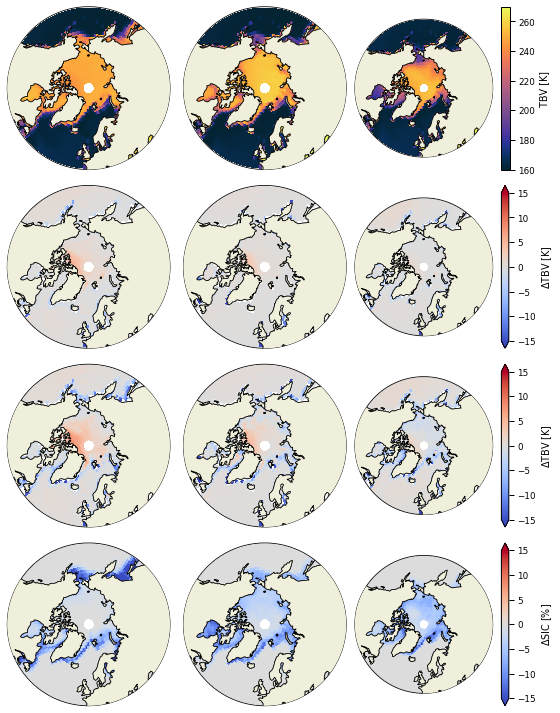

In [25]:
f = map_npstereo_compare3_coldseasons(lon,lat,TB_obs.load(),min0,max0,diff_sic_nt_bt*100,legend='yes',name='TBV',lat_lim=45,vmin=160,vmax=270,vmindiff=-15,vmaxdiff=15)
#f.savefig(plot_path+'Figure8.pdf',bbox_inches='tight',dpi=250)

In [14]:
f = map_npstereo_compare3_coldseasons(lon,lat,TB_obs.load(),min0,max0,diff_sic_nt_bt*100,legend='no',name='TBV',lat_lim=45,vmin=160,vmax=270,vmindiff=-15,vmaxdiff=15)
f.savefig(plot_path+'Figure8_withoutlegend_hole.pdf',bbox_inches='tight',dpi=250)

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
